In [2]:
'''
Set path to the folder of used python files
'''
import sys
sys.path.insert(0, '/Users/lynnjiang/liuGit/Pybook/Clinic-Analysis/Scripts/Data_Cleaning')

In [3]:
from Abstract import Abstract
import pandas as pd
import numpy as np


class Labevents(Abstract):
    def __init__(self):
        super().__init__()

#     def read_measurements_data(self, user_list, items_file='D_LABITEMS', measures_file='LABEVENTS'):
    def read_measurements_data(self, items_file='D_LABITEMS', measures_file='LABEVENTS'):
        '''
        Get measurements data with top N frequent labels.
        :param items_file:
        :param measures_file:
        :return:
        '''
        left_columns = ['SUBJECT_ID', 'ITEMID', 'VALUE', 'VALUENUM']
        right_columns = ['ITEMID', 'LABEL']
        subject_id, label, value = 'SUBJECT_ID', 'LABEL', 'VALUE'
        link_field = 'ITEMID'
        top200_labels = 'temp/LAB_TOP200_LABELS'
        num_labels = 20

        # most_frequent_items = self.read_data()
        measurements_df = self.read_data(measures_file)[left_columns]

        '''
        Select records in labevents with frequent label instead of itemid
        '''
        # measure_items_df = self.read_data(items_file)[right_columns]
        # frequent_labels = self.read_data(top200_labels)[:num_labels][label]
        # joined_meas_df = self.left_join(measurements_df, measure_items_df, link_field).dropna(subset=[value])
        # measure_filter_df = joined_meas_df[(joined_meas_df[label].isin(frequent_labels)) \
        #                                         & (joined_meas_df[subject_id].isin(user_list))]

        measure_filter_df = measurements_df.dropna(subset=[value])
        return measure_filter_df

    def get_uservectors(self, user_list, raw_measurements, min_nulls=0.8):
        '''
        min_null: fields with none values more than 80% are categorical fields, otherwise are continuous fields.
        :param user_list:
        :param raw_measurements:
        :param min_nulls:
        :return:
        '''

        value ='VALUE'
        item_id = 'ITEMID'
        ## For LABEL instead of ITEMID
        # label_id = 'LABEL'
        valuenum = 'VALUENUM'
        userid = 'SUBJECT_ID'
        labels_nulls = raw_measurements.groupby(item_id)[valuenum].apply(
            lambda x: x.isnull().sum())

        # initiate all user vectors
        #         len_all_measures = len(self.measures)
        stc_ls = ['min', 'mean', 'max', 'std']
        stc_ls_len = len(stc_ls)
        user_vectors = {}
        for user in user_list:
            user_vectors[user] = np.empty([0])

        # Groupby label
        measure_label = raw_measurements.groupby(item_id)

        for label, label_df in measure_label:

            null_percentage = labels_nulls[label] * 1.0 / len(label_df)

            if (null_percentage < min_nulls):
                # pick one iteration of continuous label
                label_df = label_df.dropna(subset=[valuenum])

                missed_users = set(user_list) - set(label_df[userid].unique())
                label_df_agg = label_df.groupby(userid)[valuenum].agg(stc_ls)

                for user, row in label_df_agg.iterrows():
                    if pd.isnull(row['std']): row['std'] = 0
                    user_vectors[user] = np.append(user_vectors[user], [row[x] for x in stc_ls])
                for user in missed_users:
                    user_vectors[user] = np.append(user_vectors[user], np.full(stc_ls_len, np.nan))

            else:
                # pick one iteration of discrete label
#                 label_df = label_df.dropna(subset=[value])
                missed_users = set(user_list) - set(label_df[userid].unique())
                label_df_agg = label_df.groupby([userid, value])[item_id].agg(['count'])
                label_df_agg_per = label_df_agg.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

                label_df_agg_per.reset_index()
                label_matrix = pd.pivot_table(label_df_agg_per,
                                              values=['count'], index=[userid], columns=[value]).fillna(0)

                for user in label_matrix.index.get_level_values(userid):
                    user_vectors[user] = np.append(user_vectors[user], label_matrix.ix[user].values)
                for user in missed_users:
                    user_vectors[user] = np.append(user_vectors[user], np.full(label_matrix.shape[1], np.nan))

        ## Reomove patients with empty record
        user_vectors_notna = pd.DataFrame(user_vectors).T.dropna(axis=0,how='all')
        ## Imputation: with mean
        user_final_vectors = user_vectors_notna.fillna(user_vectors_notna.mean())

        return user_final_vectors.rename_axis('SUBJECT_ID').reset_index()



ll = Labevents()
## Just run for one time: get seleted users and top items
# create_selected_users(ll)
selected_user_list = ll.read_data('PATIENTS')['SUBJECT_ID']
# ll.get_top_items(linkeddata,200)
# user_vectors = ll.get_uservectors(selected_user_list,ll.read_measurements_data(selected_user_list))

# ll.write2file(user_vectors,'USER_VECTORS/labtest_uservectors')
# ll.write2file(user_vectors.dropna(axis=0,how='all'),'labtest_uservectors_notna')
# ll.write2file(user_vectors.dropna(axis=1,how='all'),'labtest_uservectors_check_column')

In [ ]:
user_ve

In [5]:
raw_measurements =ll.read_measurements_data(selected_user_list)

In [6]:
value ='VALUE'
label = 'ITEMID'
valuenum = 'VALUENUM'
labels_nulls = raw_measurements.groupby(label)[valuenum].apply(
    lambda x: x.isnull().sum())
labels_nulls.head()

ITEMID
50800    404785
50801         2
50802        90
50803         4
50804        82
Name: VALUENUM, dtype: int64

In [ ]:
labels_nulls[50800]

In [ ]:
pd.DataFrame(labels_nulls)

In [11]:
test_vec = ll.get_uservectors(selected_user_list, raw_measurements[raw_measurements['ITEMID']==50800])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:98: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [12]:
test_vec.head()

,SUBJECT_ID,0,1,2,3
0,249,100.000000,0.0,0.000000,0.000000
1,250,94.152047,0.0,5.847953,0.000000
2,251,0.000000,0.0,0.000000,100.000000
3,252,77.272727,0.0,18.181818,4.545455
4,253,100.000000,0.0,0.000000,0.000000


In [14]:
raw_measurements[raw_measurements['ITEMID']==50800]['VALUE'].unique()

array(['ART', 'MIX', 'VEN', 'CENTRAL VENOUS'], dtype=object)

In [15]:
len(selected_user_list)

46520

In [17]:
selected_user_list = ll.read_data('PATIENTS')

In [18]:
selected_user_list.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [32]:
date_df = pd.DataFrame(selected_user_list['DOB'].unique()).sort_values(by=[0])

In [35]:
date_df[date_df[0]>'2000-01-01 00:00:00'].max()

0    2201-07-24 00:00:00
dtype: object

In [36]:
date_df[date_df[0]>'2000-01-01 00:00:00'].min()

0    2012-07-16 00:00:00
dtype: object

In [37]:
date_df.min()

0    1800-07-02 00:00:00
dtype: object

In [39]:
selected_user_list.quantile(0.169)

ROW_ID         7862.711
SUBJECT_ID     8312.711
EXPIRE_FLAG       0.000
Name: 0.169, dtype: float64

In [42]:
selected_user_list.sort_values(by='DOB').head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
32278,29663,31585,M,1800-07-02 00:00:00,2101-01-10 00:00:00,2101-01-10 00:00:00,2101-01-10 00:00:00,1
23011,29395,31288,F,1800-07-16 00:00:00,NaN,NaN,NaN,0
31562,36842,62884,F,1800-07-16 00:00:00,2100-11-25 00:00:00,NaN,2100-11-25 00:00:00,1
3594,3067,3240,F,1800-07-18 00:00:00,2102-01-21 00:00:00,NaN,2102-01-21 00:00:00,1
21918,28083,29851,M,1800-08-19 00:00:00,2101-08-03 00:00:00,NaN,2101-08-03 00:00:00,1


In [45]:
all_lab_uservec = ll.read_data('temp/USER_VECTORS/labtest_uservectors')

In [46]:
all_lab_uservec.shape

(46252, 6134)

In [64]:
df = pd.merge(all_lab_uservec,selected_user_list,on=['SUBJECT_ID'],how="outer",indicator=True)

In [73]:
all_lab_uservec.iloc[:,1:]

,0,1,2,3,4,5,6,7,8,9,...,6123,6124,6125,6126,6127,6128,6129,6130,6131,6132
0,100.000000,0.000000,0.000000,0.000000,407.598042,445.044071,478.526333,38.187351,-1.000000,4.360000,...,1.0,1.0,0.0,100.0,100.0,100.0,48.0,48.0,48.0,0.0
1,94.152047,0.000000,5.847953,0.000000,179.000000,570.000000,644.000000,126.141266,-23.000000,1.174699,...,1.0,1.0,0.0,100.0,100.0,100.0,48.0,48.0,48.0,0.0
2,0.000000,0.000000,0.000000,100.000000,407.598042,445.044071,478.526333,38.187351,-4.355586,-0.525971,...,1.0,1.0,0.0,100.0,100.0,100.0,48.0,48.0,48.0,0.0
3,77.272727,0.000000,18.181818,4.545455,364.000000,364.000000,364.000000,0.000000,-8.000000,-3.210526,...,1.0,1.0,0.0,100.0,100.0,100.0,48.0,48.0,48.0,0.0
4,100.000000,0.000000,0.000000,0.000000,407.598042,445.044071,478.526333,38.187351,1.000000,2.000000,...,1.0,1.0,0.0,100.0,100.0,100.0,48.0,48.0,48.0,0.0
5,84.749730,0.233436,5.880360,9.136475,407.598042,445.044071,478.526333,38.187351,-4.355586,-0.525971,...,1.0,1.0,0.0,100.0,100.0,100.0,48.0,48.0,48.0,0.0
6,94.736842,0.000000,0.000000,5.263158,558.000000,558.000000,558.000000,0.000000,-8.000000,-3.794118,...,1.0,1.0,0.0,100.0,100.0,100.0,48.0,48.0,48.0,0.0
7,84.749730,0.233436,5.880360,9.136475,407.598042,445.044071,478.526333,38.187351,-4.355586,-0.525971,...,1.0,1.0,0.0,100.0,100.0,100.0,48.0,48.0,48.0,0.0
8,84.749730,0.233436,5.880360,9.136475,407.598042,445.044071,478.526333,38.187351,-4.355586,-0.525971,...,1.0,1.0,0.0,100.0,100.0,100.0,48.0,48.0,48.0,0.0
9,84.749730,0.233436,5.880360,9.136475,407.598042,445.044071,478.526333,38.187351,-4.355586,-0.525971,...,1.0,1.0,0.0,100.0,100.0,100.0,48.0,48.0,48.0,0.0


## Python cluster visualization

In [80]:
from sklearn.decomposition import PCA
## PCA Analysis, remove the first columns which is 'SUBJECT_ID'
pca = PCA(n_components=2).fit(all_lab_uservec.iloc[:,1:])
pca_2d = pca.transform(all_lab_uservec.iloc[:,1:])

In [93]:
len(pca_2d)

46252

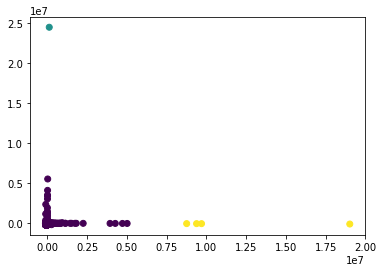

In [96]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# pl.figure('Reference Plot')
# # pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=iris.target)
kmeans = KMeans(n_clusters=3)
kmeans.fit(all_lab_uservec.iloc[:,1:])
plt.figure('K-means with 3 clusters')
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
plt.show()

In [97]:
from collections import Counter
Counter(kmeans.labels_)

Counter({0: 46247, 2: 4, 1: 1})

In [76]:
from sklearn.datasets import load_iris
iris= load_iris()
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [81]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [109]:
len(raw_measurements['ITEMID'].unique())

726